# Graph learning
This notebook is about graph learning based on the paper "Learning Heat Diffusion Graphs" written by *Dorina Thanou, Xiaowen Dong, Daniel Kressner*, and *Pascal Frossard*

### Prerequisites

In [123]:
# import numpy as np
import numpy as np

# set maximum presicion of float (for nice looking)
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

# random seed
np.random.seed(7)

### A random graph

In [124]:
import networkx as nx
import learnHeat as lh
from matplotlib import pyplot as plt
import heat_main as heat
# number of nodes
N = 20

# random grapht
plt.figure()
rg = nx.fast_gnp_random_graph(N, p = 0.2)

<Figure size 432x288 with 0 Axes>

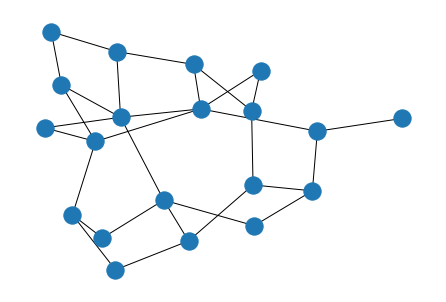

In [125]:
# figure
plt.figure()
nx.draw(rg)
plt.show()

### Graph signal based on the topology

In [126]:
# tau (ground truth)
tau_ground = [2.5, 4]

# Dictionary based on the Laplacian and tau
L_ground = nx.laplacian_matrix(rg).toarray()
D_ground = lh.D(L_ground, tau_ground)

# Number of observations
M = 100

random_atoms = []
random_hs = []
for m in range(M):
    random_atoms.append(np.random.choice(D_ground.shape[1], 3, replace=False))
    random_hs.append(np.random.randn(3))

### Observations

In [127]:
# standard deviation of noise
se = 0

# generation of observations
xs = []
H_ground = np.zeros((N*len(tau_ground),M))
for m, atom in enumerate(random_atoms):
    xs.append(np.squeeze(D_ground[:,atom]@random_hs[m]))
    H_ground[atom,m] = random_hs[m]
    
# before adding noise
X_clean = np.matrix(xs).T

# noisy observations
X = X_clean + np.sqrt(se)*np.random.randn(X_clean.shape[0],X_clean.shape[1])

### Initialize parameters (dictionary, graph, and tau)

In [128]:
rg = nx.fast_gnp_random_graph(N, p = 0.4)
L0 = nx.laplacian_matrix(rg).toarray()
L0 = L0/np.trace(L0)*N
tau0 = [1, 2]
H0 = np.random.rand(lh.D(L0, tau0).shape[1], X.shape[1])

In [129]:
result = lh.learn_heat(X = X, 
                    L0=L0, H0 = H0, tau0=tau0, 
                    verbose=False, 
                    max_iter = 50, alpha = 0.1, beta=0.1)

Learning progress:   0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Result of learning

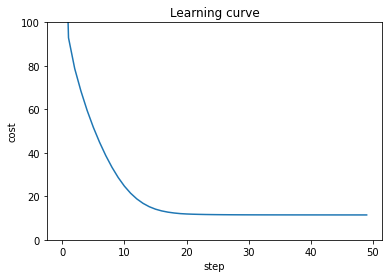

In [ ]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(result["learning_curve"]["step"], result["learning_curve"]["cost"])
plt.xlabel("step")
plt.ylabel("cost")
plt.ylim([0,100])
plt.title("Learning curve")
plt.show()

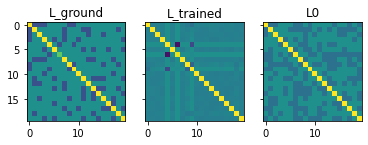

In [ ]:
vmin = -0.5
vmax = 0.5
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.imshow(L_ground/np.trace(L_ground)*N, vmin = vmin, vmax = vmax)
ax1.set_title('L_ground')
ax2.imshow(result["L"], vmin = vmin, vmax = vmax)
ax2.set_title('L_trained')
ax3.imshow(L0, vmin = vmin, vmax = vmax)
ax3.set_title('L0')
plt.show()

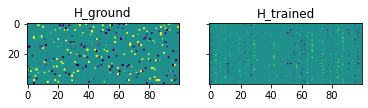

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(H_ground, vmin = vmin, vmax = vmax)
ax1.set_title('H_ground')
ax2.imshow(result["H"], vmin = vmin, vmax = vmax)
ax2.set_title('H_trained')
plt.show()